<a href="https://colab.research.google.com/github/MosheWasserb/hello-world/blob/master/Distill_Blog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init

In [74]:
# install ktrain on Google Colab
!pip install ktrain

In [70]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [75]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:
### read data from your Google Drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [76]:
# import ktrain and the ktrain.text modules
import ktrain
from ktrain import text
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [ ]:
import random
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Blog 1/1

Load emotion dataset

In [99]:
!pip install datasets
from datasets import load_dataset
emotion_dataset = load_dataset('emotion')

train_df = pd.DataFrame(list(zip(emotion_dataset['train']['text'], emotion_dataset['train']['label'])), 
               columns =['text', 'label'])

test_df = pd.DataFrame(list(zip(emotion_dataset['test']['text'], emotion_dataset['test']['label'])), 
               columns =['text', 'label'])


x_train = train_df.text.values
y_train = train_df.label.values

x_test =  test_df.text.values
y_test = test_df.label.values

value2hot = {
  0: [1,0,0,0,0,0],
  1: [0,1,0,0,0,0],
  2: [0,0,1,0,0,0],
  3: [0,0,0,1,0,0],
  4: [0,0,0,0,1,0],
  5: [0,0,0,0,0,1]
}

y_train_hotvec = np.array([value2hot[l] for l in y_train])

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/aa34462255cd487d04be8387a2d572588f6ceee23f784f37365aa714afeb8fe6)


1st  step: Set a baseline using a logistic regression model (TfIdf based)

In [100]:
model = make_pipeline(TfidfVectorizer(ngram_range=(1,1)), LogisticRegression(max_iter=200)).fit(x_train, y_train)
predicted = model.predict(x_test)
print(accuracy_score(y_test, predicted))
print(matthews_corrcoef(y_test, predicted))
print(classification_report(y_test, predicted))

0.861
0.8145907734621154
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       581
           1       0.83      0.96      0.89       695
           2       0.82      0.58      0.68       159
           3       0.90      0.81      0.85       275
           4       0.87      0.78      0.82       224
           5       0.84      0.47      0.60        66

    accuracy                           0.86      2000
   macro avg       0.86      0.75      0.79      2000
weighted avg       0.86      0.86      0.86      2000



2nd step: Deep Learning baseline

In [101]:
NUM_CLASS = 6
MAX_NUM_WORDS = 5000
MAX_LEN = 64 
EPOCHS = 15

In [102]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GlobalAveragePooling1D, GlobalMaxPool1D, GlobalMaxPooling1D, Dense, Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Concatenate, Flatten
from keras.initializers import Constant
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, f1_score, classification_report
from matplotlib import pyplot as plt
import tensorflow as tf

In [82]:
# Tokenization Option A
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Avoid UNK words 
X = np.concatenate((x_train, x_test), axis=0)

# Tokenize our training data
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(x_train)

# Get max training sequence length
  #maxlen = min(max_len_const, max([len(x) for x in train_sequences]))
maxlen = MAX_LEN

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Encode test data sentences into sequences
test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

In [128]:
# Tokenization Option B
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize our training data
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token = '<UNK>')
tokenizer.fit_on_texts(x_train)

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(x_train)

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Encode test data sentences into sequences
test_sequences = tokenizer.texts_to_sequences(x_test)

# Pad the training sequences
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)


In [90]:
from tensorflow.keras import layers

class Attention(layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.units = units
        self.W1 = Dense(units)
        self.V = Dense(1)

    def get_config(self):
        return {"units": self.units}
 
    def call(self, features):
        score = tf.nn.tanh(self.W1(features))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [129]:
# Model MLP_Attn  
embedding_layer = Embedding(MAX_NUM_WORDS,
                            output_dim=16,
                            embeddings_initializer='uniform',
                            input_length=MAX_LEN,
                            trainable=True)

sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
context_vector, attention_weights = Attention(8)(embedded_sequences)

dense1 = Dense(16, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
preds = Dense(NUM_CLASS, activation='softmax')((dropout))
model = Model(sequence_input, preds)

model.compile(optimizer='adam', loss='KLD',metrics=['accuracy'])

In [130]:
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 64)]              0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 64, 16)            80000     
_________________________________________________________________
attention_26 (Attention)     ((None, 16), (None, 64, 1 145       
_________________________________________________________________
dense_88 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 6)                 102       
Total params: 80,519
Trainable params: 80,519
Non-trainable params: 0
______________________________________________________

In [131]:
callbacks_list = [
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy', mode='max', save_best_only=True, verbose=0),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)]

custom_objects = {"Attention": Attention}

history = model.fit(
  train_padded,
  y_train_hotvec,  
  epochs=EPOCHS,
  batch_size=512,
  validation_split=0.1,
  shuffle=True,
  verbose=0,
  callbacks=callbacks_list)
  
saved_model = load_model('best_model.h5', custom_objects)
logits_pred = saved_model.predict(test_padded, batch_size=64, verbose=1)
y_pred_bool = np.argmax(logits_pred, axis=1)


32/32 [==============================] - 0s 1ms/step


In [132]:
print(accuracy_score(y_test, y_pred_bool))
print(classification_report(y_test, y_pred_bool))

0.901
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       581
           1       0.92      0.93      0.92       695
           2       0.79      0.78      0.78       159
           3       0.89      0.90      0.89       275
           4       0.87      0.91      0.89       224
           5       0.69      0.62      0.66        66

    accuracy                           0.90      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.90      0.90      0.90      2000



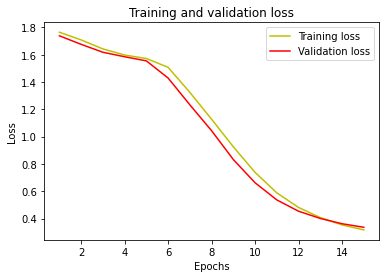

In [93]:
# Plot the training and validation accuracu and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

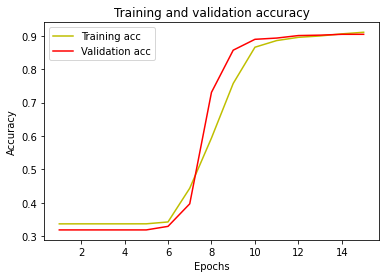

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

3rd step: Transformers models 

In [133]:
categories = ['0','1','2','3','4','5']

In [ ]:
MODEL_NAME = 'bert-base-uncased'    # Select from HuggigFace model Hub 
t = text.Transformer(MODEL_NAME, maxlen=64, class_names=categories)   # maxlen: emotion = 64, SST-2 = 64
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32) # lower bs if OOM occurs
learner.fit_onecycle(2e-5, 2)

4th step: DistillBERT

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'    # Select from HuggigFace model Hub 
t = text.Transformer(MODEL_NAME, maxlen=64, class_names=categories)   # maxlen: emotion = 64, SST-2 = 64
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32) # lower bs if OOM occurs
learner.fit_onecycle(2e-5, 2)

5th: Distill Roberta to a simpler student


In [ ]:
MODEL_NAME = 'roberta-base'    # Select from HuggigFace model Hub 
t = text.Transformer(MODEL_NAME, maxlen=64, class_names=categories)   # maxlen: emotion = 64, SST-2 = 64
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32) # lower bs if OOM occurs
learner.fit_onecycle(2e-5, 2)

In [ ]:
# Load augmented data (un-labeled)
aug_df = pd.read_csv('/gdrive/My Drive/DataSet/ED6/data_augmentation_ED6.csv')    # Provide augmented data file 
x_aug = aug_df.text.values

In [ ]:
# Psedu-label the aug data with RoBERTa
predictor = ktrain.get_predictor(learner.model, preproc, batch_size=64)
y_aug_hotvec = predictor.predict_proba(x_aug)

In [ ]:
# Distill to MLP_Attn 
callbacks_list = [
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy', mode='max', save_best_only=True, verbose=0),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)]

custom_objects = {"Attention": Attention}

history = model.fit(
  aug_padded,
  y_aug_hotvec,  
  epochs=EPOCHS,
  batch_size=512,
  validation_split=0.1,
  shuffle=True,
  verbose=0,
  callbacks=callbacks_list)
  
saved_model = load_model('best_model.h5', custom_objects)
logits_pred = saved_model.predict(test_padded, batch_size=64, verbose=1)
y_pred_bool = np.argmax(logits_pred, axis=1)

In [ ]:
# Evaluation 
print(accuracy_score(y_test, y_pred_bool))
print(classification_report(y_test, y_pred_bool))

# Blog 2/3

Load SST2 dataset

In [135]:
train_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

test_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/test.tsv', delimiter='\t', header=None)

text=train_df.columns.values[0] 
label=train_df.columns.values[1]

x_train = train_df[text].values
y_train = train_df[label].values

x_test =  test_df[text].values
y_test = test_df[label].values

value2hot = {
  0: [1,0,],
  1: [0,1]
}

y_train_hotvec = np.array([value2hot[l] for l in y_train])

1st  step: Set a baseline using a logistic regression model (TfIdf based)

In [136]:
model = make_pipeline(TfidfVectorizer(ngram_range=(1,1)), LogisticRegression(max_iter=200)).fit(x_train, y_train)
predicted = model.predict(x_test)
print(accuracy_score(y_test, predicted))
print(matthews_corrcoef(y_test, predicted))
print(classification_report(y_test, predicted))

0.7913234486545854
0.5838751598218017
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       912
           1       0.77      0.82      0.80       909

    accuracy                           0.79      1821
   macro avg       0.79      0.79      0.79      1821
weighted avg       0.79      0.79      0.79      1821



2nd step: Deep Learning baseline

In [154]:
NUM_CLASS = 2
MAX_NUM_WORDS = 15000
MAX_LEN = 64 
EPOCHS = 5
EMBEDDING_DIM=100

In [152]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GlobalAveragePooling1D, GlobalMaxPool1D, GlobalMaxPooling1D, Dense, Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Concatenate, Flatten
from keras.initializers import Constant
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, f1_score, classification_report
from matplotlib import pyplot as plt
import tensorflow as tf

In [153]:
# Tokenization Option B
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize our training data
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token = '<UNK>')
tokenizer.fit_on_texts(x_train)

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(x_train)

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Encode test data sentences into sequences
test_sequences = tokenizer.texts_to_sequences(x_test)

# Pad the training sequences
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

In [143]:
from tensorflow.keras import layers

class Attention(layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.units = units
        self.W1 = Dense(units)
        self.V = Dense(1)

    def get_config(self):
        return {"units": self.units}
 
    def call(self, features):
        score = tf.nn.tanh(self.W1(features))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [144]:
# Model MLP_Attn  
embedding_layer = Embedding(MAX_NUM_WORDS,
                            output_dim=16,
                            embeddings_initializer='uniform',
                            input_length=MAX_LEN,
                            trainable=True)

sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
context_vector, attention_weights = Attention(8)(embedded_sequences)

dense1 = Dense(16, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
preds = Dense(NUM_CLASS, activation='softmax')((dropout))
model = Model(sequence_input, preds)

model.compile(optimizer='adam', loss='KLD',metrics=['accuracy'])

In [157]:
# Model Bi-LSTM
embedding_layer = Embedding(MAX_NUM_WORDS,
                            EMBEDDING_DIM,
                            embeddings_initializer='uniform',  # Constant(embedding_matrix)
                            input_length=MAX_LEN,
                            trainable=True)
sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
x = Bidirectional(LSTM(64))(x)
x = Dropout(0.5)(x)
preds = Dense(NUM_CLASS, activation='softmax')(x)
model = Model(sequence_input, preds)

model.compile(optimizer='adam', loss='KLD',metrics=['accuracy'])

In [ ]:
model.summary()

In [159]:
callbacks_list = [
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy', mode='max', save_best_only=True, verbose=0),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)]

custom_objects = {"Attention": Attention}

history = model.fit(
  train_padded,
  y_train_hotvec,  
  epochs=EPOCHS,
  batch_size=512,
  validation_split=0.1,
  shuffle=True,
  verbose=0,
  callbacks=callbacks_list)
  
saved_model = load_model('best_model.h5', custom_objects)
logits_pred = saved_model.predict(test_padded, batch_size=64, verbose=1)
y_pred_bool = np.argmax(logits_pred, axis=1)

29/29 [==============================] - 3s 59ms/step


In [160]:
print(accuracy_score(y_test, y_pred_bool))
print(classification_report(y_test, y_pred_bool))

0.7847336628226249
              precision    recall  f1-score   support

           0       0.80      0.75      0.78       912
           1       0.77      0.82      0.79       909

    accuracy                           0.78      1821
   macro avg       0.79      0.78      0.78      1821
weighted avg       0.79      0.78      0.78      1821



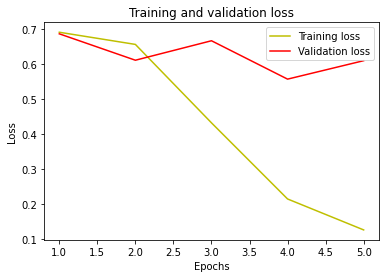

In [161]:
# Plot the training and validation accuracu and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

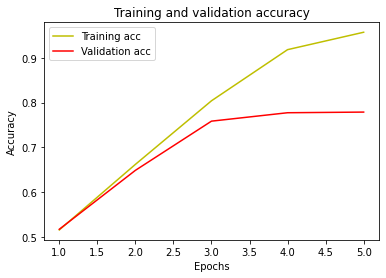

In [162]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

3rd step: Transformers models 

In [ ]:
categories = ['0','1']

In [ ]:
MODEL_NAME = 'bert-base-uncased'    # Select from HuggigFace model Hub 
t = text.Transformer(MODEL_NAME, maxlen=64, class_names=categories)   # maxlen: emotion = 64, SST-2 = 64
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32) # lower bs if OOM occurs
learner.fit_onecycle(2e-5, 2)

4th step: DistillBERT

In [ ]:
MODEL_NAME = 'distillbert'    # Select from HuggigFace model Hub 
t = text.Transformer(MODEL_NAME, maxlen=64, class_names=categories)   # maxlen: emotion = 64, SST-2 = 64
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32) # lower bs if OOM occurs
learner.fit_onecycle(2e-5, 2)

5th: Distill Roberta to a simpler student


In [ ]:
MODEL_NAME = 'roberta'    # Select from HuggigFace model Hub 
t = text.Transformer(MODEL_NAME, maxlen=64, class_names=categories)   # maxlen: emotion = 64, SST-2 = 64
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32) # lower bs if OOM occurs
learner.fit_onecycle(2e-5, 2)

In [ ]:
# Load augmented data (un-labeled)
aug_df = pd.read_csv('/gdrive/My Drive/DataSet/ED6/data_augmentation_ED6.csv')    # Provide augmented data file 
x_aug = aug_df.text.values

In [ ]:
# Psedu-label the aug data with RoBERTa
predictor = ktrain.get_predictor(learner.model, preproc, batch_size=64)
y_aug_hotvec = predictor.predict_proba(x_aug)

In [ ]:
# Distill to MLP_Attn 
callbacks_list = [
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy', mode='max', save_best_only=True, verbose=0),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)]

custom_objects = {"Attention": Attention}

history = model.fit(
  aug_padded,
  y_aug_hotvec,  
  epochs=EPOCHS,
  batch_size=512,
  validation_split=0.1,
  shuffle=True,
  verbose=0,
  callbacks=callbacks_list)
  
saved_model = load_model('best_model.h5', custom_objects)
logits_pred = saved_model.predict(test_padded, batch_size=64, verbose=1)
y_pred_bool = np.argmax(logits_pred, axis=1)

In [ ]:
# Evaluation 
print(accuracy_score(y_test, y_pred_bool))
print(classification_report(y_test, y_pred_bool))

# Blog 3/3

Load IMDB dataset

In [ ]:
!pip install datasets
from datasets import load_dataset
imdb_dataset = load_dataset('imdb')

train_df = pd.DataFrame(list(zip(imdb_dataset['train']['text'], imdb_dataset['train']['label'])), 
               columns =['text', 'label'])

test_df = pd.DataFrame(list(zip(imdb_dataset['test']['text'], imdb_dataset['test']['label'])), 
               columns =['text', 'label'])

#train_df=train_df.sample(1000)

x_train = train_df.text.values
y_train = train_df.label.values

x_test =  test_df.text.values
y_test = test_df.label.values

value2hot = {
  0: [1,0],
  1: [0,1]
}

y_train_hotvec = np.array([value2hot[l] for l in y_train])

1st  step: Set a baseline using a logistic regression model (TfIdf based)

In [ ]:
model = make_pipeline(TfidfVectorizer(ngram_range=(1,1)), LogisticRegression(max_iter=200)).fit(x_train, y_train)
predicted = model.predict(x_test)
print(accuracy_score(y_test, predicted))
print(matthews_corrcoef(y_test, predicted))
print(classification_report(y_test, predicted))

2nd step: Deep Learning baseline

In [ ]:
NUM_CLASS = 2
MAX_NUM_WORDS = 5000
MAX_LEN = 256 
EPOCHS = 15

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GlobalAveragePooling1D, GlobalMaxPool1D, GlobalMaxPooling1D, Dense, Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Concatenate, Flatten
from keras.initializers import Constant
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, f1_score, classification_report
from matplotlib import pyplot as plt
import tensorflow as tf

In [ ]:
# Tokenization Option A
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Avoid UNK words 
X = np.concatenate((x_train, x_test), axis=0)

# Tokenize our training data
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(x_train)

# Get max training sequence length
  #maxlen = min(max_len_const, max([len(x) for x in train_sequences]))
maxlen = MAX_LEN

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Encode test data sentences into sequences
test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

In [ ]:
# Tokenization Option B
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize our training data
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token = '<UNK>')
tokenizer.fit_on_texts(x_train)

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(x_train)

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Encode test data sentences into sequences
test_sequences = tokenizer.texts_to_sequences(x_test)

# Pad the training sequences
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)


In [ ]:
from tensorflow.keras import layers

class Attention(layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.units = units
        self.W1 = Dense(units)
        self.V = Dense(1)

    def get_config(self):
        return {"units": self.units}
 
    def call(self, features):
        score = tf.nn.tanh(self.W1(features))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [ ]:
# Model MLP_Attn  
embedding_layer = Embedding(MAX_NUM_WORDS,
                            output_dim=16,
                            embeddings_initializer='uniform',
                            input_length=MAX_LEN,
                            trainable=True)

sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
context_vector, attention_weights = Attention(8)(embedded_sequences)

dense1 = Dense(16, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
preds = Dense(NUM_CLASS, activation='softmax')((dropout))
model = Model(sequence_input, preds)

model.compile(optimizer='adam', loss='KLD',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 64)]              0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 64, 16)            80000     
_________________________________________________________________
attention_26 (Attention)     ((None, 16), (None, 64, 1 145       
_________________________________________________________________
dense_88 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 6)                 102       
Total params: 80,519
Trainable params: 80,519
Non-trainable params: 0
______________________________________________________

In [ ]:
callbacks_list = [
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy', mode='max', save_best_only=True, verbose=0),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)]

custom_objects = {"Attention": Attention}

history = model.fit(
  train_padded,
  y_train_hotvec,  
  epochs=EPOCHS,
  batch_size=512,
  validation_split=0.1,
  shuffle=True,
  verbose=0,
  callbacks=callbacks_list)
  
saved_model = load_model('best_model.h5', custom_objects)
logits_pred = saved_model.predict(test_padded, batch_size=64, verbose=1)
y_pred_bool = np.argmax(logits_pred, axis=1)


32/32 [==============================] - 0s 1ms/step


In [ ]:
print(accuracy_score(y_test, y_pred_bool))
print(classification_report(y_test, y_pred_bool))

0.901
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       581
           1       0.92      0.93      0.92       695
           2       0.79      0.78      0.78       159
           3       0.89      0.90      0.89       275
           4       0.87      0.91      0.89       224
           5       0.69      0.62      0.66        66

    accuracy                           0.90      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.90      0.90      0.90      2000



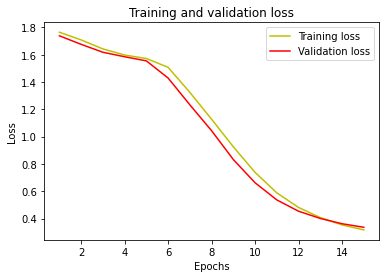

In [ ]:
# Plot the training and validation accuracu and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

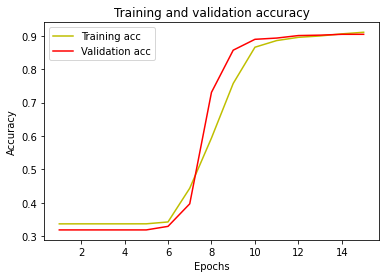

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

3rd step: Transformers models 

In [ ]:
categories = ['0','1','2','3','4','5']

In [ ]:
MODEL_NAME = 'bert-base-uncased'    # Select from HuggigFace model Hub 
t = text.Transformer(MODEL_NAME, maxlen=64, class_names=categories)   # maxlen: emotion = 64, SST-2 = 64
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32) # lower bs if OOM occurs
learner.fit_onecycle(2e-5, 2)

4th step: DistillBERT

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'    # Select from HuggigFace model Hub 
t = text.Transformer(MODEL_NAME, maxlen=64, class_names=categories)   # maxlen: emotion = 64, SST-2 = 64
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32) # lower bs if OOM occurs
learner.fit_onecycle(2e-5, 2)

5th: Distill Roberta to a simpler student


In [ ]:
MODEL_NAME = 'roberta-base'    # Select from HuggigFace model Hub 
t = text.Transformer(MODEL_NAME, maxlen=64, class_names=categories)   # maxlen: emotion = 64, SST-2 = 64
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32) # lower bs if OOM occurs
learner.fit_onecycle(2e-5, 2)

In [ ]:
# Load augmented data (un-labeled)
aug_df = train_df    # Provide 25000 training data 
x_aug = aug_df.text.values

In [ ]:
# Psedu-label the aug data with RoBERTa
predictor = ktrain.get_predictor(learner.model, preproc, batch_size=64)
y_aug_hotvec = predictor.predict_proba(x_aug)

In [ ]:
# Distill to MLP_Attn 
callbacks_list = [
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy', mode='max', save_best_only=True, verbose=0),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)]

custom_objects = {"Attention": Attention}

history = model.fit(
  aug_padded,
  y_aug_hotvec,  
  epochs=EPOCHS,
  batch_size=512,
  validation_split=0.1,
  shuffle=True,
  verbose=0,
  callbacks=callbacks_list)
  
saved_model = load_model('best_model.h5', custom_objects)
logits_pred = saved_model.predict(test_padded, batch_size=64, verbose=1)
y_pred_bool = np.argmax(logits_pred, axis=1)

In [ ]:
# Evaluation 
print(accuracy_score(y_test, y_pred_bool))
print(classification_report(y_test, y_pred_bool))

WOS